In [165]:
using Plots
using SparseArrays
using LinearAlgebra
using Arpack

In [166]:
import LowLevelFEM as FEM
using LowLevelFEM
using SparseArrays

gmsh.initialize()

In [167]:
gmsh.open("rectangle.geo")

Info    : Reading 'rectangle.geo'...
Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 30%] Meshing curve 2 (Line)
Info    : [ 50%] Meshing curve 3 (Line)
Info    : [ 80%] Meshing curve 4 (Line)
Info    : Done meshing 1D (Wall 0.000262711s, CPU 0.000258s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Transfinite)
Info    : Done meshing 2D (Wall 7.0577e-05s, CPU 6.8e-05s)
Info    : 4 nodes 9 elements
Info    : Done reading 'rectangle.geo'


In [168]:
mat = FEM.material("body", E=2.e5, ν=0.0, ρ=7.85e-9)
problem = FEM.Problem([mat], type="PlaneStress")

Info    : RCMK renumbering...
Info    : Done RCMK renumbering (bandwidth is now 3)


LowLevelFEM.Problem("rectangle", "PlaneStress", 2, [("body", 200000.0, 0.0, 7.85e-9)], 1.0, 4)

In [169]:
supp1 = FEM.displacementConstraint("left", ux=0)
supp2 = FEM.displacementConstraint("bottom", uy=0)

("bottom", 0 + 1im, 0, 0 + 1im)

In [170]:
dof = problem.non * problem.dim

8

In [171]:
K = FEM.stiffnessMatrix(problem)

8×8 SparseMatrixCSC{Float64, Int64} with 64 stored entries:
 100000.0          -25000.0          …       5.45697e-12  -25000.0
 -25000.0          100000.0              25000.0          -50000.0
 -50000.0          -25000.0             -50000.0          -25000.0
  25000.0               5.45697e-12     -25000.0          -50000.0
 -50000.0           25000.0             -50000.0           25000.0
  25000.0          -50000.0          …  -25000.0               5.45697e-12
      5.45697e-12   25000.0             100000.0           25000.0
 -25000.0          -50000.0              25000.0          100000.0

In [172]:
M = FEM.massMatrix(problem)

8×8 SparseMatrixCSC{Float64, Int64} with 8 stored entries:
 1.9625e-9   ⋅          ⋅         …   ⋅          ⋅          ⋅ 
  ⋅         1.9625e-9   ⋅             ⋅          ⋅          ⋅ 
  ⋅          ⋅         1.9625e-9      ⋅          ⋅          ⋅ 
  ⋅          ⋅          ⋅             ⋅          ⋅          ⋅ 
  ⋅          ⋅          ⋅             ⋅          ⋅          ⋅ 
  ⋅          ⋅          ⋅         …  1.9625e-9   ⋅          ⋅ 
  ⋅          ⋅          ⋅             ⋅         1.9625e-9   ⋅ 
  ⋅          ⋅          ⋅             ⋅          ⋅         1.9625e-9

In [173]:
f = zeros(dof);

In [174]:
Tₘᵢₙ = FEM.smallestPeriodTime(K, M)

6.224001709051478e-7

In [175]:
1 / √(2e5 / 7.85e-9) * π

6.224001709051479e-7

In [176]:
ξₘₐₓ = 0.01
β = ξₘₐₓ * Tₘᵢₙ / 2π
invM = spdiagm(1 ./ diag(M))
β2 = ξₘₐₓ / 2 / (2π / Tₘᵢₙ)^3
C1 = β * K #u1, v1, t1 = FEM.CDM(K, M, C, f, u0, v0, 100Tₘᵢₙ, Tₘᵢₙ / π)
C2 = β * K + β2 * K * invM * K #u1, v1, t1 = FEM.CDM(K, M, C, f, u0, v0, 100Tₘᵢₙ, Tₘᵢₙ / π)

8×8 SparseMatrixCSC{Float64, Int64} with 64 stored entries:
  0.000142396  -3.71468e-5   -6.81024e-5   …   6.19113e-6   -3.71468e-5
 -3.71468e-5    0.000142396  -3.71468e-5       3.71468e-5   -6.81024e-5
 -6.81024e-5   -3.71468e-5    0.000142396     -8.04847e-5   -3.71468e-5
  3.71468e-5    6.19113e-6    3.71468e-5      -3.71468e-5   -8.04847e-5
 -8.04847e-5    3.71468e-5    6.19113e-6      -6.81024e-5    3.71468e-5
  3.71468e-5   -8.04847e-5    3.71468e-5   …  -3.71468e-5    6.19113e-6
  6.19113e-6    3.71468e-5   -8.04847e-5       0.000142396   3.71468e-5
 -3.71468e-5   -6.81024e-5   -3.71468e-5       3.71468e-5    0.000142396

In [177]:
FEM.applyBoundaryConditions!(problem, K, M, C1, f, [supp1, supp2]);

In [178]:
O = spzeros(dof, dof)
A = [I O
    O -M]
B = [O I
    K C1]
λ, ϕ = Arpack.eigs(B, A, nev=2dof, which=:LM)
a = [abs.(λ) -real.(λ) ./ abs.(λ)]
#λ

┌ Warning: Adjusting nev from 16 to 14
└ @ Arpack /home/perebal/.julia/packages/Arpack/FCvNd/src/Arpack.jl:92


14×2 Matrix{Float64}:
 8.74291e6  0.00432998
 8.74291e6  0.00432998
 7.13815e6  0.00353561
 7.13815e6  0.00353561
 7.13693e6  0.00353622
 7.13693e6  0.00353622
 5.04795e6  0.0024998
 5.04795e6  0.0024998
 1.0        0.499999
 1.0        0.499999
 1.0        0.5
 1.0        0.5
 1.0        0.5
 1.0        0.5

In [179]:
a = reverse(a, dims=1)

14×2 Matrix{Float64}:
 1.0        0.5
 1.0        0.5
 1.0        0.5
 1.0        0.5
 1.0        0.499999
 1.0        0.499999
 5.04795e6  0.0024998
 5.04795e6  0.0024998
 7.13693e6  0.00353622
 7.13693e6  0.00353622
 7.13815e6  0.00353561
 7.13815e6  0.00353561
 8.74291e6  0.00432998
 8.74291e6  0.00432998

In [180]:
λ, ϕ = eigen(collect(B), collect(A), sortby=abs)
b = [abs.(λ) -real.(λ) ./ abs.(λ)]
#λ

16×2 Matrix{Float64}:
 1.0        0.5
 1.0        0.5
 1.0        0.5
 1.0        0.5
 1.0        0.5
 1.0        0.5
 1.0        0.5
 1.0        0.5
 5.04754e6  0.0025
 5.04754e6  0.0025
 7.13831e6  0.00353553
 7.13831e6  0.00353553
 7.13831e6  0.00353553
 7.13831e6  0.00353553
 8.7426e6   0.00433013
 8.7426e6   0.00433013

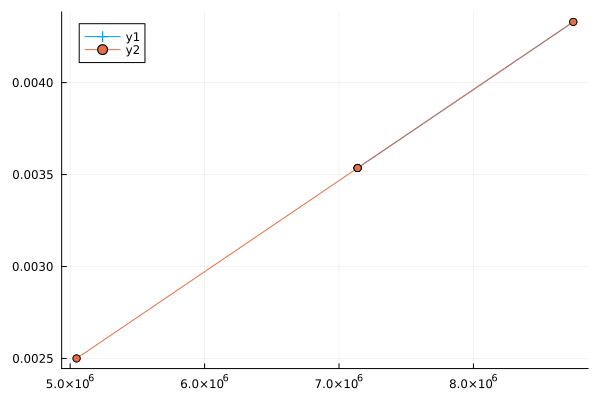

In [183]:
plot([a[9:14, 1], b[9:16, 1]], [a[9:14, 2], b[9:16, 2]], shape=:auto)

In [182]:
gmsh.finalize()